<h1>WFA for $B_{LOS}$</h1>

This is a jupyter notebook that reads the output from RH runs and calculates LOS component of magnetic field using the WFA. We will use the equation for the weak field approximation for the line of sight component of the magnetic field: 

>$ V = -C B_{LOS} \frac{\partial I}{\partial \lambda}$


where:

>$C = 4.6686^{-13}* \lambda_0^2 * g_{eff}$

where $\lambda$ is in Angstroms, and, for Ca II 8542 Ang 

>$\lambda_0 = 8542.0857$ Ang 

>$g_{eff} = 1.10$ 


In [1]:
# First some imports
import glob
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import rhanalyze
from rhanalyze.rhatmos import input_atmos


In [2]:
# and some styling
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


In [3]:
# Some constants for the Ca II 8542 spectral line
lam0 = 8542.09  # central wavelength in Angs
geff = 1.10     # Effective Lande factor
C = 4.6686e-13 * lam0**2. * geff   ## For wavelength in Angs

# choose a wavelength to evaluate the local continuum (in Angs). This is just to get an arbitrary normalizing factor
wl_cont = 8530.0

In [4]:
# names of the RH output directories we want to read
rhoutputs = glob.glob('../rhf1d/run_Blos*G_000')
rhoutputs.sort()
print(rhoutputs)



['../rhf1d/run_Blos_100G_000', '../rhf1d/run_Blos_200G_000', '../rhf1d/run_Blos_300G_000', '../rhf1d/run_Blos_400G_000', '../rhf1d/run_Blos_500G_000']


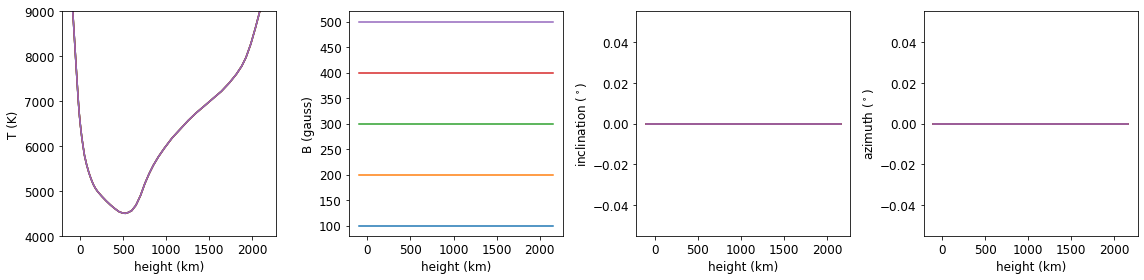

In [25]:
# Read each output directory and plot the atmospheres
KM_TO_M = 1.0E3

fig, ax = plt.subplots(1,4, figsize = (16, 4))
ax[0].set_ylim(4000, 9000)
ax[0].set_ylabel('T (K)')
ax[1].set_ylabel('B (gauss)')
ax[2].set_ylabel(r'inclination ($^\circ$)')
ax[3].set_ylabel(r'azimuth ($^\circ$)')
for jj in range(4):
    ax[jj].set_xlabel('height (km)')

for Brun in rhoutputs:
    # Read the input atmospheres from RH's output directory
    falc = rhanalyze.rhout(Brun) 
    height = falc.geometry.height/ KM_TO_M
    tau500 = falc.geometry.tau500

# Plot the Temperature and magnetic field vector as a function of height
    ax[0].plot(height, falc.atmos.T)
    ax[1].plot(height, falc.atmos.B*10**4)
    ax[2].plot(height, falc.atmos.gamma_B*180./np.pi)
    ax[3].plot(height, falc.atmos.chi_B*180./np.pi)


plt.tight_layout()

<h1> Are we in the weak field regime?</h1>

Let's see how $\frac{\bar g \Delta\lambda_B}{\Delta\lambda_D}$ varies as a function of height and magnetic field strength. Where:

$\bar g \Delta\lambda_B = 4.67 \cdot 10^{-13} \bar g \lambda_0^2 B$

$\Delta\lambda_D = \lambda_0/c \sqrt{\frac{2 K_B T}{\mu M_A}+\xi^2}$

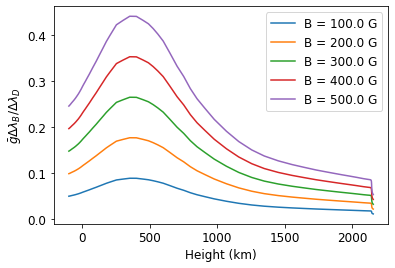

In [27]:
c = 3e8 #speed of light in m/s
mu = 40.078 # atomic weight of calcium
M = 1.66e-27 # kg (atomic mass unit)
Kb = 1.38E-23 # m^2 kg s^-2 K^-1 (Boltzmann constant)
#dir(falc.atmos)
fig, ax = plt.subplots(figsize = (6,4))
ax.set_xlabel('Height (km)')
ax.set_ylabel(r'$\bar g \Delta\lambda_B / \Delta\lambda_D$')

for Brun in rhoutputs:
    # Read the input atmospheres from RH's output directory
    falc = rhanalyze.rhout(Brun) 
    Bvalue = falc.atmos.B[0]*1e4 # magnetic field strength
    height = falc.geometry.height/ KM_TO_M
    Doppler = lam0/c * np.sqrt(2. * Kb * falc.atmos.T/mu/M + falc.atmos.vturb**2.)
    Zeeman = 4.67 * 1e-13 * geff * lam0**2. * falc.atmos.B*1e4 # (convert B to gauss)
    ax.plot(falc.geometry.height/ KM_TO_M, Zeeman/Doppler, label='B = '+str(Bvalue)+' G')

ax.legend()


<h2> Plotting the spectra. Are we in the weak field regime? </h2>

Now let's have a look at the Stokes spectra. We're only plotting Stokes I and V, since in this example, Q and U are zero because the magnetic field is along the line of sight (and there is no scattering polarization).
We will plot Stokes I, Stokes V, and then Stokes V scaled by the inverse of the field strength. 

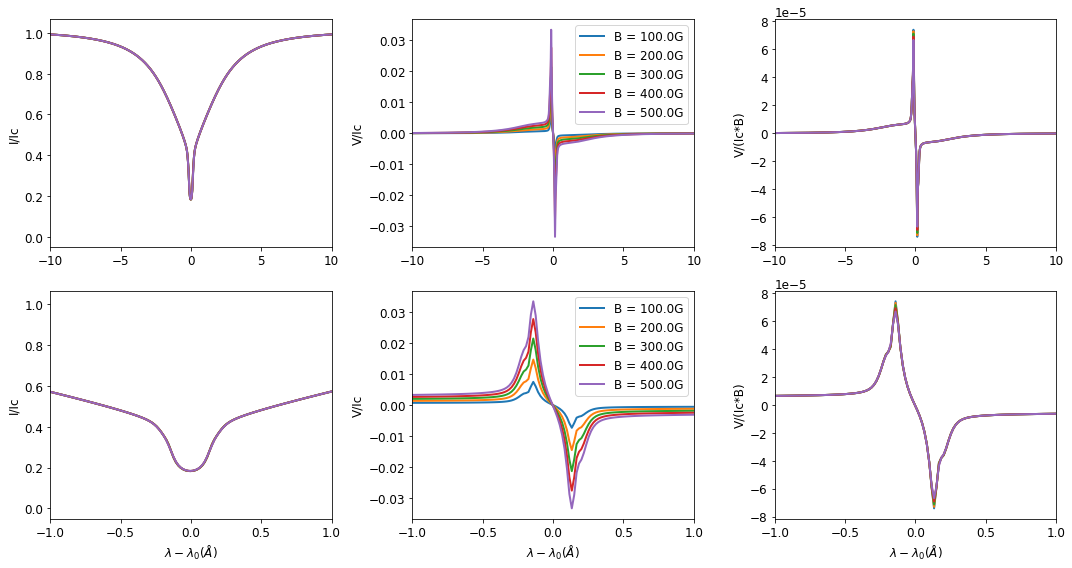

In [22]:
# Read each output directory and plot the Stokes I and V spectra


fig, ax = plt.subplots(2,3, figsize = (15, 8))

# Read the RH output from 5 runs for magnetic fields between 100 and 500 G
for Brun in rhoutputs:
    falc = rhanalyze.rhout(Brun) 
    lam = falc.spectrum.waves *10 # convert to Angs

    # Find wavelength index for continuum wavelength
    idx_cont = (np.abs(lam - wl_cont)).argmin()
    I = falc.rays[0].I
    Icont = I[idx_cont] # continuum intensity
    I = I/Icont
    V = falc.rays[0].V /Icont
    # Get model magnetic field strength value. It's constant with height, so we choose the field for height index = 0
    Bvalue = falc.atmos.B[0]*10**4 

### FIGURE: Plot the Stokes I and Stokes V as a function of wavelength
    ax[0,0].plot(lam-lam0, I, label='B = '+str(Bvalue), linewidth=2.0)
    ax[0,1].plot(lam-lam0, V, linewidth=2.0 , label='B = '+str(Bvalue)+'G')    
    ax[0,2].plot(lam-lam0, V/Bvalue, linewidth=2.0, label='B = '+str(Bvalue)+'G') 
    ax[1,0].plot(lam-lam0, I, label='B = '+str(Bvalue), linewidth=2.0)
    ax[1,1].plot(lam-lam0, V, linewidth=2.0 , label='B = '+str(Bvalue)+'G')    
    ax[1,2].plot(lam-lam0, V/Bvalue, linewidth=2.0, label='B = '+str(Bvalue)+'G') 
for kk in range(2):
    ax[kk,0].set_ylabel('I/Ic')
    ax[kk,1].set_ylabel('V/Ic')
    ax[kk,2].set_ylabel('V/(Ic*B)')
for jj in range(3):
    ax[1,jj].set_xlabel(r'$\lambda -\lambda_0 (\AA)$')
    ax[1,jj].set_xlim(-1, 1)
    ax[0,jj].set_xlim(-10, 10)

ax[0,1].legend()
ax[1,1].legend()

plt.tight_layout()

<h2>Calculating $B_{LOS}$</h2>

Now let's use the weak field approximation to derive the line-of-sight magnetic field, Blos. Try doing the calculation in the core and the wing of the line, separately!




-- Bmodel = 100.0 G
       Bfit  =  98.0 Gauss, with intercept = 1.7906689140759585e-06
       Error = -2.01%
-- Bmodel = 200.0 G
       Bfit  = 196.0 Gauss, with intercept = 3.750872355140631e-06
       Error = -2.00%
-- Bmodel = 300.0 G
       Bfit  = 294.0 Gauss, with intercept = 6.144849455773253e-06
       Error = -2.00%
-- Bmodel = 400.0 G
       Bfit  = 391.9 Gauss, with intercept = 9.376369609561261e-06
       Error = -2.03%
-- Bmodel = 500.0 G
       Bfit  = 489.5 Gauss, with intercept = 1.3863771697576122e-05
       Error = -2.09%


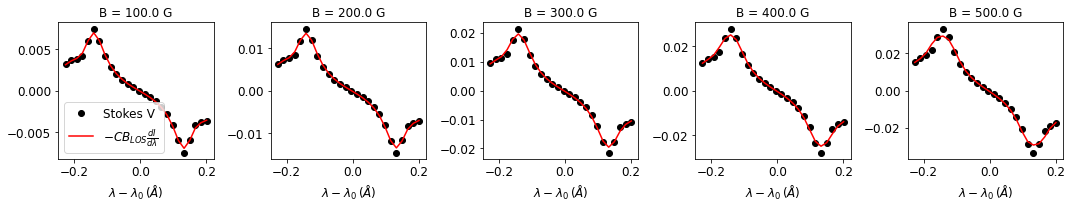

In [24]:

# Wavelength range to chop spectral line of interest (in our case, Ca II 8542)

# wing of line
wl1 = 8538.0
wl2 = 8541.01

# line core only
wl1 = 8541.85
wl2 = 8542.3


## Start figure
fig, ax = plt.subplots(1,5, figsize = (15, 3))

# Read RH ouput directories
for Brun in rhoutputs:
    
    # Read the output from each RH run directory into the falc variable 
    falc = rhanalyze.rhout(Brun) 
    # get model magnetic field value
    Bvalue = falc.atmos.B[0]*10**4 #convert from Tesla to Gauss
    # Get wavelength vector
    lam = falc.spectrum.waves *10 # convert to Angs
    # Find wavelenght index for continuum wavelength
    idx_cont = (np.abs(lam - wl_cont)).argmin()
    I = falc.rays[0].I
    Icont = I[idx_cont]
    I = I/Icont
    V = falc.rays[0].V /Icont

    
    # derivative of I with respect to wavelength. 
    # We calculate it over the entire wavelength grid and then cut out the spectral line 
    # to avoid edge-effects from the derivative
    dIdlam = np.gradient(I, lam)

    # Cut out wavelength range around Ca II 8542
    indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))  
    lam_line = np.squeeze(lam[indlam])
    Vline = np.squeeze(V[indlam])
    dIdlam_line = np.squeeze(dIdlam[indlam])

    # Calculate Blos
    # Perform a linear fit of Stokes V to -C*dI/dlam to obtain Blos

    Bfit = P.polyfit(-C*dIdlam_line, Vline, 1)
    
    #Print out results
    print('-- Bmodel = '+str(Bvalue)+' G' )
    print('       Bfit  = ' +format(Bfit[1], '5.1f') + ' Gauss, with intercept = '+str(Bfit[0]))  
    print('       Error = '+ format((Bfit[1]-Bvalue)/Bvalue*100, '3.2f')+ "%")

    # plot Stokes V and overplot dI/dlam scaled with C and Blos
    ax[int(Bvalue/100-1)].plot(lam_line - lam0, Vline, 'ko', label='Stokes V')
    ax[int(Bvalue/100-1)].plot(lam_line-lam0, -Bfit[1]*C*dIdlam_line, 'r-', label=r'$-C B_{LOS}\frac{dI}{d\lambda}$') 
    ax[int(Bvalue/100-1)].set_title('B = '+str(Bvalue)+' G')
    ax[int(Bvalue/100-1)].set_xlabel(r'$\lambda - \lambda_0\, (\AA) $')
ax[0].legend()
plt.tight_layout()

<h3>Note the very similar values you get when you run it on the core and the wing of the spectral line. This is because the magnetic field is constant along the LOS. There is still enough signal in the wing of Stokes V to obtain a reliable value of $B_{LOS}$. </h3>